## Introduction
The dataset collected can be found in the kaggle link below. The data is divided by some car makers. I used the Hyundai data.
The information gathered is used cars in the United Kingdom. The data was previously cleaned by the author, and thus very little data wrangling is needed.

My goal with this dataset is to predict the price of a used car depending on the available features.
This same notebook can work for other car maker datasets available in the kaggle link. I decided to use only the Hyundai data because I have considered buying their car.

https://www.kaggle.com/adityadesai13/used-car-dataset-ford-and-mercedes


First I'll import the libraries and then read in the file. Again it is mostly clean due to the kaggle author doing the data cleaning. 


In [2]:
# !pip install category_encoders==2.*
# !pip install pdpbox

# imports
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.linear_model import Ridge
from sklearn.ensemble import RandomForestRegressor

from sklearn.metrics import mean_absolute_error, r2_score
from sklearn.model_selection import train_test_split, RandomizedSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler

from category_encoders import OneHotEncoder

from pdpbox.pdp import pdp_isolate, pdp_plot, pdp_interact, pdp_interact_plot


In [3]:
filepath = 'hyundi.csv'

def wrangle(filepath):
      df = pd.read_csv(filepath, skipinitialspace=True)
      df.columns = ['model','year','price','transmission','mileage','fuelType','tax','mpg','engineSize']
        # The original data set inclues the pound sign in the tax column name, so I renamed it
      return df

df = wrangle(filepath)
df.head(5)

,model,year,price,transmission,mileage,fuelType,tax,mpg,engineSize
0,I20,2017,7999,Manual,17307,Petrol,145,58.9,1.2
1,Tucson,2016,14499,Automatic,25233,Diesel,235,43.5,2.0
2,Tucson,2016,11399,Manual,37877,Diesel,30,61.7,1.7
3,I10,2016,6499,Manual,23789,Petrol,20,60.1,1.0
4,IX35,2015,10199,Manual,33177,Diesel,160,51.4,2.0


We can see that there are a few different models by Hyundai. There is also different transmission types. Fueltype also includes petrol (AKA gasoline in the US), diesel, hybrid, and full electric.

## Splitting the data
The next step is to divide our data. We are going to predict the **price** of cars based on the available features. This includes the model of the car, year, transmission type etc. If a person wants to buy a Hyundai car, they can check the engine size, year, transmission and mileage to see if they are getting a fair price. 

The price will be put into 'y'. We'll make a train test split to divide it into test and training sets. Then we'll further divide our test set into validation and test data. Lastly we will print out the length of each data split to make sure we divided correctly.

In [4]:
target='price'
X = df.drop(columns=target)
y = df[target]

# Let's split into a test and
X_train, X_t, y_train, y_t = train_test_split(X,y, test_size=.2, random_state=7)

# Let's split our test data into validation and test
X_val, X_test, y_val, y_test = train_test_split(X_t,y_t, test_size=.2, random_state=7)

print('Training:', len(X_train))
print('Validation:', len(X_val))
print('Test:', len(X_test))

Training: 3888
Validation: 777
Test: 195


## Linear Regression - Ridge

We are going to make a model using linear regression to predict the price. I picked ridge regression. We will be using Mean Absolute Error since we have some cars that are more expensive than the rest. We will then check MAE for the training and validation data portions. 

In [5]:
# Baseline Accuracy with Mean Absolute Error
print('Ridge Regression')

y_pred = len(y_train) *[y_train.mean()]
baseline_mae = mean_absolute_error(y_train,y_pred)
print('Baseline MAE: ', baseline_mae)

# instantiate and  fit the model
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                      StandardScaler(),
                      Ridge(random_state=7))
model.fit(X_train,y_train);

# Mean Absolute Error
# Training
trai_acc = mean_absolute_error(y_train,model.predict(X_train))
print('Training MAE: ', trai_acc)

# Validation
y_pred_val = model.predict(X_val)
val_acc = mean_absolute_error(y_val,y_pred_val)
print('Valdiation MAE: ',val_acc)

# R Squared validation - Validation
print('Rsquared Validation:', r2_score(y_val,model.predict(X_val)))

Ridge Regression
Baseline MAE:  4603.597470294797
Training MAE:  1450.0524431447088
Valdiation MAE:  1501.4782597954018
Rsquared Validation: 0.8707720774282759


We can see an improvement in the MAE from the baseline. To further improve we will do some hyperparameter tuning. 

## Ridge Regression Tuning

We will be using randomized search to tune 4 different parameters. Then we will input these parameters into our model and check the MAE with the improved model.

In [6]:
# Tuning the model using Randomized Search CV
param_grid = {'ridge__alpha': range(0,50,10),       
              'ridge__fit_intercept': [True,False],
              'ridge__normalize': [True,False],
             'ridge__solver': ['svd', 'cholesky', 'lsqr', 'sparse_cg', 'sag', 'saga']}

model_rscv = RandomizedSearchCV(model,
                                param_distributions=param_grid,
                                n_iter=10,
                                cv=None,
                                n_jobs=-1,
                                verbose=1)

model_rscv.fit(X_val, y_val);
model_rscv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'ridge__solver': 'cholesky',
 'ridge__normalize': False,
 'ridge__fit_intercept': True,
 'ridge__alpha': 10}

In [8]:
# These tuned hyperparameters will now be inside the model

# Baseline Accuracy with Mean Absolute Error
print('Ridge Regression while tuning hyperparameters')

print('Baseline MAE: ', baseline_mae)

# fit the model with hyperparameters
model = make_pipeline(OneHotEncoder(use_cat_names=True),
                      StandardScaler(),
                      Ridge(normalize=False,fit_intercept=True,alpha=10,solver='cholesky'))
model.fit(X_train,y_train);


# Mean Absolute Error Score
# Training
trai_acc = mean_absolute_error(y_train,model.predict(X_train))
print('Training MAE: ', trai_acc)

# Validation
y_pred_val = model.predict(X_val)
val_acc = mean_absolute_error(y_val,y_pred_val)
print('Valdiation MAE: ',val_acc)

# R Squared validation - Validation
print('Rsquared Validation:', r2_score(y_val,model.predict(X_val)))

Ridge Regression while tuning hyperparameters
Baseline MAE:  4603.597470294797
Training MAE:  1449.458238279129
Valdiation MAE:  1500.489699870183
Rsquared Validation: 0.8708593995529115


We see that our validation improved after including tuning the hyperparameters. Although it improved, it was only by 1 point in the validation accuracy.
Next we will try another model regression to see how it performs.

## Random Forest Regression

For this portion we will use the Random Forest Regressor. We are trying to predict a continuous variable, so a regressor is the way to go instead of a classifier tree based model. As we did previously, we will hyperparameter tune after we have a baseline of the model.

In [9]:
model_rf = make_pipeline(OneHotEncoder(),
                         RandomForestRegressor(random_state=70))
model_rf.fit(X_train,y_train);

In [10]:
# Mean Absolute Error Accuracy Score
# Training
print('Random Forest Regressor')

print('Baseline MAE: ', baseline_mae)

training_acc = mean_absolute_error(y_train,model_rf.predict(X_train))
print('MAE Train: ', training_acc)

# Validation
val_acc = mean_absolute_error(y_val,model_rf.predict(X_val))
print('MAE Validation: ',val_acc)

# R squared
print('Rsquared Validation:', r2_score(y_val, model_rf.predict(X_val)))


Random Forest Regressor
Baseline MAE:  4603.597470294797
MAE Train:  336.12814894272145
MAE Validation:  862.1598470601401
Rsquared Validation: 0.9571037815486978


The MAE is better for the random forest than it was for the tuned ridge regression. Now we will continue to tune the random forest.

## Tuning the Random Forest Regressor
This time, we will tune the n estimators, max depth, and max leaf nodes. Again we will be using randomized search to find they best parameters.

In [11]:
#Tuning the Random Forest Regressor
param_grid = {'randomforestregressor__n_estimators': range(5,100,5),       
              'randomforestregressor__max_depth': range(5,100,5),
              'randomforestregressor__max_leaf_nodes': range(50,300,20)}

model_rscv = RandomizedSearchCV(model_rf,
                                param_distributions=param_grid,
                                n_iter=10,
                                cv=None,
                                n_jobs=-1,
                                verbose=1)

model_rscv.fit(X_val, y_val);
model_rscv.best_params_

Fitting 5 folds for each of 10 candidates, totalling 50 fits


{'randomforestregressor__n_estimators': 90,
 'randomforestregressor__max_leaf_nodes': 270,
 'randomforestregressor__max_depth': 20}

In [12]:
# Inputting the hyperparameters into our model

model_rf = make_pipeline(OneHotEncoder(),
                         RandomForestRegressor(random_state=7,
                                n_estimators=90,
                                max_leaf_nodes=270,
                                max_depth=20))
model_rf.fit(X_train,y_train);

# Mean Absolute Error Accuracy Score
# Training
print('Random Forest Regressor')

print('Baseline MAE: ', baseline_mae)

training_acc = mean_absolute_error(y_train,model_rf.predict(X_train))
print('MAE Train: ', training_acc)

# Validation
val_acc = mean_absolute_error(y_val,model_rf.predict(X_val))
print('MAE Validation: ',val_acc)

# R squared
print('Rsquared Validation:', r2_score(y_val, model_rf.predict(X_val)))

Random Forest Regressor
Baseline MAE:  4603.597470294797
MAE Train:  607.1175890601079
MAE Validation:  818.1967302212537
Rsquared Validation: 0.9615440097451574


Without tuning the random forest performed better than the ridge regression. Once we tuned this mode, the MAE dropped by 44 points. For this reason, we will be using this model on our test data.

## Test data on model

We can see that our model can set your car price above or below "fair" price by £904. With this amount you can negotiate with the dealer, or be warned that a car is being sold is overpriced.

In [13]:
test_acc = mean_absolute_error(y_test,model_rf.predict(X_test))
print('MAE Test:', test_acc)

MAE Test: 904.2972048141785


## Feature Importances
Let's look at feature importances, to determine if we should keep all or edit the features we use to train our model.

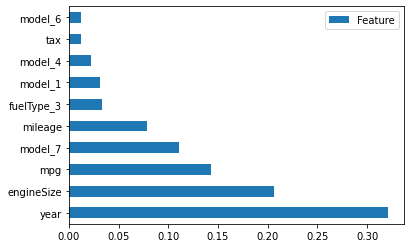

In [15]:
model_rf_coef = model_rf.named_steps['randomforestregressor'].feature_importances_
model_features = model_rf.named_steps['onehotencoder'].feature_names
model_rf_info = pd.DataFrame(data=model_rf_coef, 
                             index=model_features,
                             columns=['Feature']).sort_values(by='Feature',
                                                           ascending=False,
                                                             key=abs).head(10)
model_rf_info.plot(kind='barh');
# plt.sh

We find that the continious features have a higher impact than categorical. Model_7 (Santa Fe) is generally going to drive the price up of a car. It's a more expensive car than the rest of the Hyundai brand maker cars. For this reason, we will keep the model, as it has a high impact as individual models. 

## Isolating features

Next we will dive deeper into the year feature. It was our top criteria for price fluctuation. In the below graph we can see that cars that are newer (within 5 years) are deemed more valuable. Then once a car reaches the 5 year old mark, the decline in price is linear. For those trying to be frugal, it would be best to buy a car at this price, since the value is diminished less steeply than newer cars.

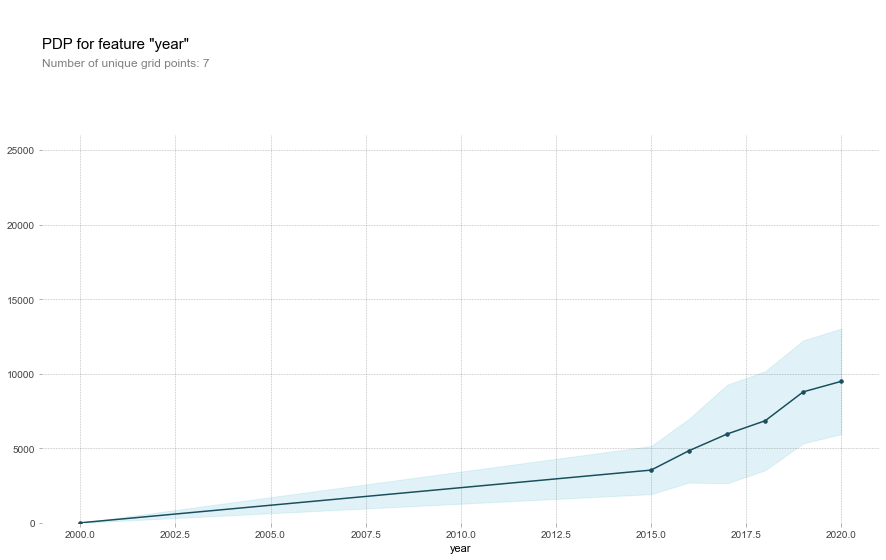

In [21]:
# isolating the year feature
feature = 'year'

isolate = pdp_isolate(
    model_rf,
    dataset = X_test,
    model_features = X_test.columns,
    feature=feature
)

pdp_plot(isolate, feature_name=feature);

## Features interact

Next we will look at how year and mileage interact with price of cars. High mileage cars are riskier as their 'life span' end approaches. 

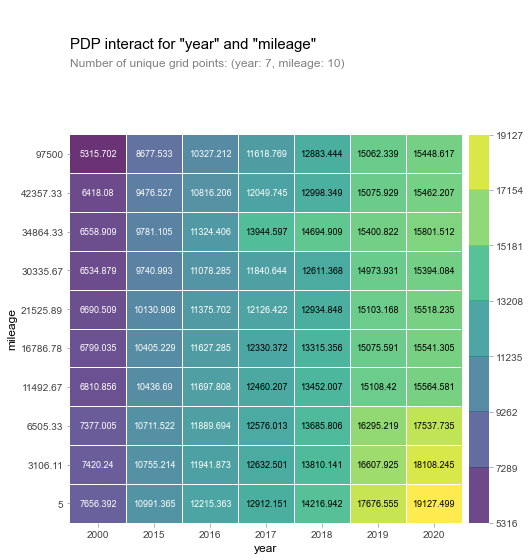

In [66]:
features = ['year', 'mileage']

interact = pdp_interact(
    model_rf,
    dataset = X_test,
    model_features = X_test.columns,
    features=features
)

pdp_interact_plot(interact, plot_type='grid', feature_names=features);

We saw that some of our top features were year and mileage. Generally with cars you want cars that have lower mileage. This chart shows us that regardless of mileage, newer cars go for higher prices.

## Conclusion
While using our model you can find a price range for a car you are looking for. This data does not account for other features a car might have. Some models come with rear cameras, heated seats, or other features that might reduce or increase the price of a car. This is what the rest of our Rsquared is missing. Another point is that some cars are maintainted by their owners well, while some might be more neglectful. 

Something to note regarding our data. In our dataset we have some engine sizes that have values of 0.0. This does not mean that they are cars without engines. This refers to cars that are completely electric. This might affect how our model conducts.

The tax of each car is decided by government, and it depends on the year of the car, fuel type, and carbon emissions. We could change the target prediction to tax if we were the government trying to decided how much to tax per car.

Overall you can use this model to check what a car's value should be, and look at the details to determine the rest of the price.